In [1]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [2]:
# CARREGAR OS DADOS

def carregar_ecgs(unlabel, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, unlabel) if len(ecg_normal_id) >= unlabel else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X , ids_ecgs

In [9]:
X, ids_ecgs = carregar_ecgs(unlabel=1000,umdavb=100,rbbb=100,lbbb=100,sb=100,st=100,af=100,filtrado=True)


Número de linhas ecg_normal_linhas: 272407
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 252167
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 1600
Número de ecgs que eram pra ser processados: 1600
Número total de traçados processados: 1600


In [4]:
print(ids_ecgs[1])

1992850


In [ ]:
# salvar_grafos_ecg.py
import torch
import numpy as np
from ts2vg import NaturalVG
import random

# =============================================================================
# Função para calcular as features de cada nó:
#   - amplitude: valor da amostra;
#   - derivada: diferença com o nó anterior (primeiro nó = 0);
#   - grau: número de arestas incidentes.
# =============================================================================
def compute_node_features(time_series, edges):
    """
    time_series: numpy array de forma (n,), contendo os valores da lead.
    edges: lista de tuplas (i, j) definindo as arestas do grafo.
    Retorna:
        features: numpy array de forma (n, 3) com [amplitude, derivada, grau] para cada nó.
    """
    n = len(time_series)
    # amplitude: o valor da amostra já está na série
    amplitude = time_series.reshape(-1, 1)
    
    # derivada: o primeiro valor é zero; depois, a diferença entre elementos consecutivos
    derivative = np.zeros(n)
    derivative[1:] = np.diff(time_series)
    derivative = derivative.reshape(-1, 1)
    
    # grau: conta quantas vezes cada nó aparece nas arestas (grafo não direcionado)
    degree = np.zeros(n)
    for (u, v) in edges:
        degree[u] += 1
        degree[v] += 1
    degree = degree.reshape(-1, 1)
    
    # Concatenar as features: cada nó terá [amplitude, derivada, grau]
    features = np.hstack([amplitude, derivative, degree])
    return features

# =============================================================================
# SUPOSIÇÕES:
# - Você já tem o array de ECGs "X" obtido da função carregar_ecgs.
#   Cada ECG tem formato (12, n_samples).
# - A lista "ids_ecgs" (ou "exam_ids_list") contém os exam_ids correspondentes, na mesma ordem de X.
# =============================================================================

# Exemplo: para fins deste código, vamos supor que X e ids_ecgs já estejam definidos.
# REMOVA ESSE BLOCO se você já tiver as variáveis definidas
exam_ids_list = ids_ecgs  # certifique-se de que 'ids_ecgs' já esteja definido
# ------------------------------------------------------------------------------

# Cria um dicionário para armazenar os grafos por exam_id.
# Cada exam_id terá um dicionário com 12 chaves ("lead_0" a "lead_11"), 
# cada uma contendo os tensores do grafo para aquela lead.
graphs_by_exam = {}

print("Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...")
for idx, ecg in enumerate(X):
    exam_id = exam_ids_list[idx]
    graphs_by_exam[exam_id] = {}  # dicionário para armazenar os grafos de cada lead deste exame
    
    for lead_index in range(12):
        # Obter a série temporal da lead (vetor numpy de forma (n_samples,))
        lead_series = ecg[lead_index]
        
        # Constrói o grafo de visibilidade para a lead usando NaturalVG
        vg = NaturalVG()
        vg.build(lead_series)
        edges = vg.edges  # lista de arestas, cada aresta é uma tupla (i, j)
        
        # Calcular as features de cada nó: [amplitude, derivada, grau]
        node_features = compute_node_features(lead_series, edges)  # numpy array de forma (n, 3)
        
        # Converter as arestas para tensor do PyTorch.
        # Se houver arestas, converte para tensor e extrai src e dst a partir do edge_index (forma [2, num_edges])
        if len(edges) > 0:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape (2, num_edges)
        else:
            # Caso não haja arestas, cria um tensor vazio com forma (2, 0)
            edge_index = torch.empty((2, 0), dtype=torch.long)
        
        # Converter as features para tensor (tipo float)
        node_features_tensor = torch.tensor(node_features, dtype=torch.float)
        
        # Salvar os dados do grafo para esta lead
        graphs_by_exam[exam_id][f"lead_{lead_index}"] = {
            "edge_index": edge_index,           # tensor com a conectividade (2, num_edges)
            "node_features": node_features_tensor  # tensor com as features dos nós (n, 3)
        }
    
    print(f"Processado exam_id {exam_id} ({idx+1}/{len(X)})")

# Organiza os dados salvos em um único dicionário. Aqui, a chave 'grafos' contém
# o dicionário com os grafos indexados pelo exam_id.
dados_salvos = {
    "grafos": graphs_by_exam
}

# Salvar o dicionário com os grafos em um arquivo .pt
output_filename = "ecg_visibility_graphs_by_id.pt"
torch.save(dados_salvos, output_filename)
print(f"Grafos salvos com sucesso em {output_filename}")


Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...


Processado exam_id 44898 (1/1600)
Processado exam_id 1992850 (2/1600)
Processado exam_id 555716 (3/1600)
Processado exam_id 1163783 (4/1600)
Processado exam_id 208929 (5/1600)
Processado exam_id 3020848 (6/1600)
Processado exam_id 1469525 (7/1600)
Processado exam_id 782098 (8/1600)
Processado exam_id 355728 (9/1600)
Processado exam_id 1009611 (10/1600)
Processado exam_id 243456 (11/1600)
Processado exam_id 575695 (12/1600)
Processado exam_id 4408290 (13/1600)
Processado exam_id 1073632 (14/1600)
Processado exam_id 1195684 (15/1600)
Processado exam_id 1173501 (16/1600)
Processado exam_id 218448 (17/1600)
Processado exam_id 786404 (18/1600)
Processado exam_id 1522582 (19/1600)
Processado exam_id 1031731 (20/1600)
Processado exam_id 110550 (21/1600)
Processado exam_id 1580875 (22/1600)
Processado exam_id 1431723 (23/1600)
Processado exam_id 2872752 (24/1600)
Processado exam_id 525960 (25/1600)
Processado exam_id 88845 (26/1600)
Processado exam_id 3061972 (27/1600)
Processado exam_id 39852

/tmp/ipykernel_206971/1075903989.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exam_id = list(torch.load(pt_path)['grafos'].keys())[9]
/tmp/ipykernel_206971/10759039

Grafo do exam_id 1009611 - lead 7 criado com 4096 nós e 76969 arestas.


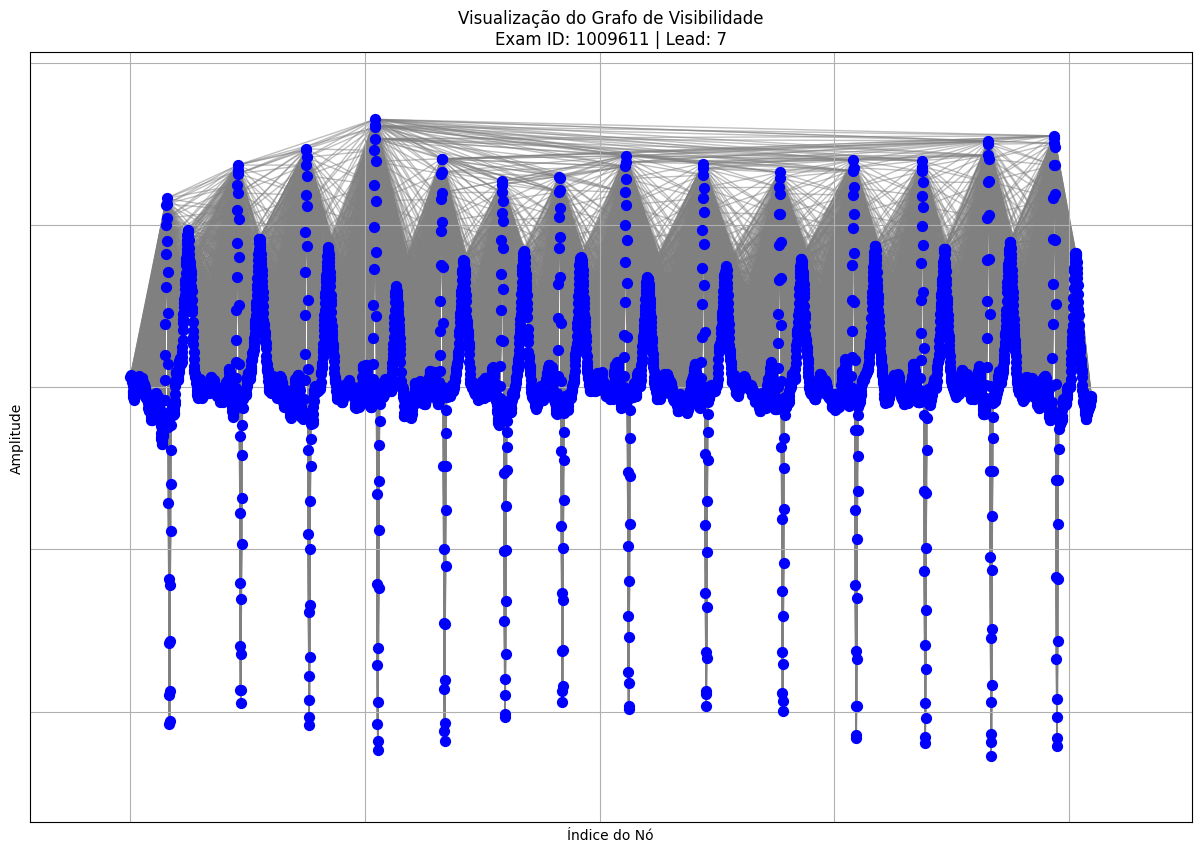

/tmp/ipykernel_206971/1075903989.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dados_salvos = torch.load(pt_path)


Grafo do exam_id 1009611 - lead 7 criado com 4096 nós e 76969 arestas.


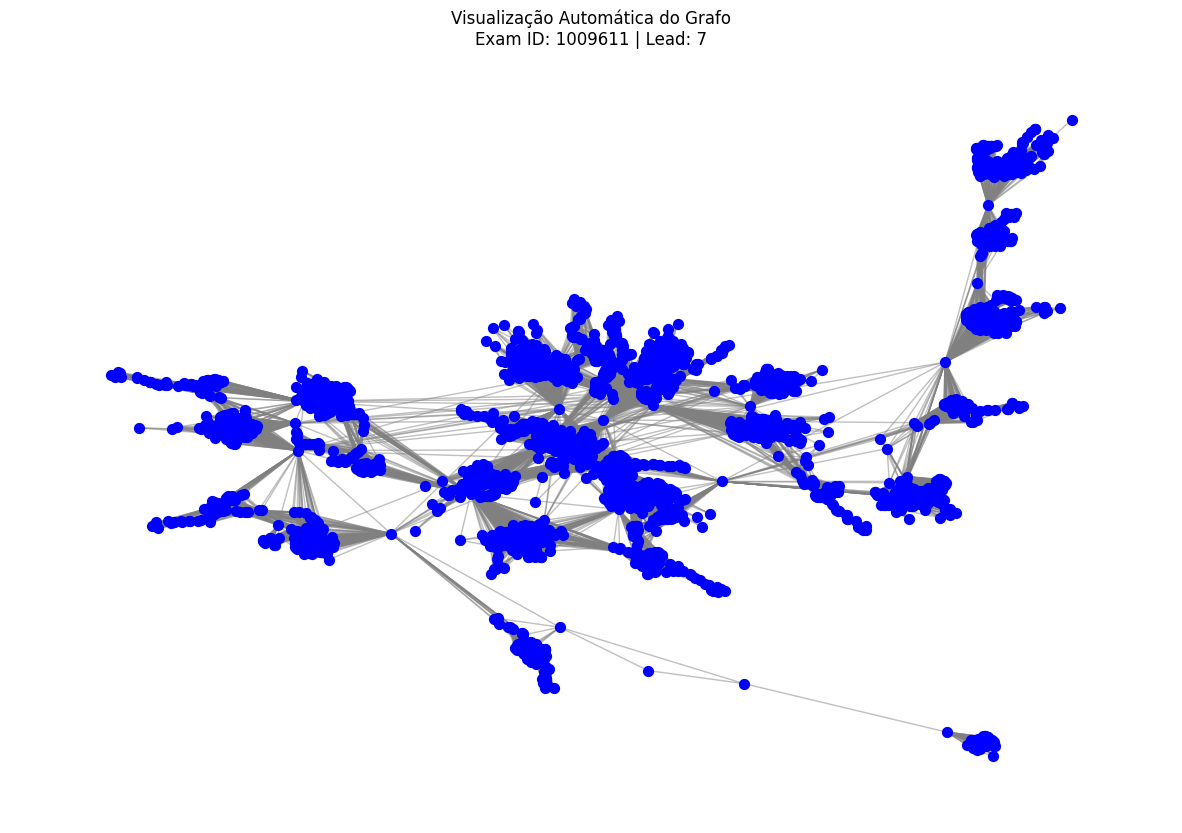

In [6]:
# visualizar_grafo.py
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def visualizar_grafo_com_matplotlib(pt_path, exam_id, lead_index):
    """
    Carrega os tensores salvos em um arquivo .pt e visualiza o grafo de um ECG especificado, 
    para um dado exam_id e lead, usando Matplotlib.
    Nesta visualização os nós são posicionados de acordo com seu índice e o valor da amplitude (coluna 0).

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos organizados por exam_id.
        exam_id (str/int): O ID do exame (deve estar presente nas chaves do dicionário salvo).
        lead_index (int): Índice da lead a ser visualizada (0 a 11).
    """
    try:
        dados_salvos = torch.load(pt_path)
        grafos_by_exam = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    if exam_id not in grafos_by_exam:
        print(f"Exam ID '{exam_id}' não encontrado nos dados salvos.")
        return

    exam_dict = grafos_by_exam[exam_id]
    key_lead = f"lead_{lead_index}"
    if key_lead not in exam_dict:
        print(f"Lead {lead_index} não encontrada para o exame {exam_id}.")
        return

    graph_data = exam_dict[key_lead]
    edge_index = graph_data["edge_index"]  # tensor shape: [2, num_edges]
    node_features = graph_data["node_features"]  # tensor shape: [num_nodes, 3]
    
    # Extraia o vetor original da amplitude (coluna 0) para posicionar os nós
    amplitude = node_features[:, 0].cpu().numpy()  # vetor de forma (num_nodes,)
    
    # Converte as arestas para numpy
    edges = edge_index.cpu().numpy()  # shape (2, num_edges)

    # Verifica a consistência: o número de nós esperado
    num_nodes = len(amplitude)
    if edges.size > 0:
        max_node = int(max(np.max(edges[0]), np.max(edges[1])))
        if max_node >= num_nodes:
            print("Atenção: O vetor de amplitude não cobre todos os nós do grafo.")
            num_nodes = max_node + 1

    # Cria o grafo com NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    if edges.size > 0:
        G.add_edges_from(zip(edges[0], edges[1]))
    print(f"Grafo do exam_id {exam_id} - lead {lead_index} criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Define as posições dos nós: x = índice do nó, y = amplitude
    pos = {i: (i, amplitude[i]) for i in range(len(amplitude))}

    # Plotagem
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    plt.title(f"Visualização do Grafo de Visibilidade\nExam ID: {exam_id} | Lead: {lead_index}")
    plt.xlabel("Índice do Nó")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


def visualizar_apenas_grafo_com_matplotlib(pt_path, exam_id, lead_index):
    """
    Carrega os tensores salvos em um arquivo .pt e visualiza apenas o grafo de um ECG especificado, 
    para um dado exam_id e lead, utilizando o layout automático do NetworkX.

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        exam_id (str/int): O ID do exame (deve estar presente nos dados).
        lead_index (int): Índice da lead a ser visualizada (0 a 11).
    """
    try:
        dados_salvos = torch.load(pt_path)
        grafos_by_exam = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    if exam_id not in grafos_by_exam:
        print(f"Exam ID '{exam_id}' não encontrado.")
        return

    exam_dict = grafos_by_exam[exam_id]
    key_lead = f"lead_{lead_index}"
    if key_lead not in exam_dict:
        print(f"Lead {lead_index} não encontrada para o exame {exam_id}.")
        return

    graph_data = exam_dict[key_lead]
    edge_index = graph_data["edge_index"]  # tensor shape: [2, num_edges]
    edges = edge_index.cpu().numpy()  # shape (2, num_edges)

    # Cria o grafo com NetworkX (apenas com as arestas)
    G = nx.Graph()
    if edges.size > 0:
        G.add_edges_from(zip(edges[0], edges[1]))
    print(f"Grafo do exam_id {exam_id} - lead {lead_index} criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Layout automático (spring layout)
    pos = nx.spring_layout(G)

    # Plotagem
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    plt.title(f"Visualização Automática do Grafo\nExam ID: {exam_id} | Lead: {lead_index}")
    plt.axis("off")
    plt.show()


# Exemplo de uso:
if __name__ == "__main__":
    # Caminho para o arquivo .pt salvo (no nosso caso, 'ecg_visibility_graphs_by_id.pt')
    pt_path = "ecg_visibility_graphs_by_id.pt"
    
    # Defina o exam_id e a lead que você deseja visualizar.
    # Por exemplo, se o exam_id está salvo como uma string ou número, ajuste conforme seus dados.
    exam_id = list(torch.load(pt_path)['grafos'].keys())[9]
    exam_id = 1009611 
    # pega o primeiro exam_id disponível
    lead_index = 7  # por exemplo, visualize a lead 0
    
    # Visualiza o grafo com o vetor original (posição dos nós definida por índice e amplitude)
    visualizar_grafo_com_matplotlib(pt_path, exam_id, lead_index)
    
    # Visualiza apenas o grafo com layout automático
    visualizar_apenas_grafo_com_matplotlib(pt_path, exam_id, lead_index)
